# 3.7 softmax回归的简洁实现
- **目录**
  - 3.7.1 初始化模型参数
  - 3.7.2 重新审视Softmax的实现
  - 3.7.3 优化算法
  - 3.7.4 训练

- 通过深度学习框架的高级API能更方便地实现softmax回归模型。
- 本节继续使用Fashion-MNIST数据集，并保持批量大小为256。

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 3.7.1 初始化模型参数

- **softmax回归的输出层是一个全连接层**。
- 模型只需在`Sequential`中添加一个带有10个输出的全连接层。
- 这里`Sequential`并不是必要的，但它是实现深度模型的基础，因此仍使用这个类。
- 仍然以均值0和标准差0.01随机初始化权重。


In [3]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
'''
由于本例使用小批量随机梯度下降算法，batch_size=256，
因此每次计算时Flatten层将(256,28,28)形状展平为(256,784)，
后面的相关注释和说明以此类推。
'''
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights);

---------

- **说明：net内部结构**
- （1）net[1]保存Linear类的对象：
  - net[1]是一个全连接层。
  - apply函数将参数应用到模型的所有子模型，比如net中的所有Linear层，然后对参数进行初始化。
  - 本例中只对权重按照自定义的**正态分布**函数进行初始化，而偏置仍是使用默认初始化方法.
  - 对于权重和偏置的默认初始化是使用服从:   $\mathcal{U}(-\sqrt{k}, \sqrt{k})$ 其中
           $k = \frac{1}{\text{in\_features}}$的均匀分布采样随机数。

In [4]:
## nn.Linear的确有weight和bias属性，在模型开始训练之前需初始化
net[1], net[1].weight.shape, net[1].bias.shape, net[1].weight, net[1].bias

(Linear(in_features=784, out_features=10, bias=True),
 torch.Size([10, 784]),
 torch.Size([10]),
 Parameter containing:
 tensor([[-0.0024, -0.0031,  0.0052,  ...,  0.0074,  0.0132, -0.0029],
         [-0.0040,  0.0026,  0.0053,  ...,  0.0159,  0.0120, -0.0115],
         [-0.0096, -0.0056,  0.0047,  ..., -0.0020,  0.0112, -0.0064],
         ...,
         [ 0.0017,  0.0087, -0.0097,  ...,  0.0076,  0.0138,  0.0171],
         [-0.0128,  0.0050,  0.0055,  ..., -0.0087, -0.0035, -0.0205],
         [-0.0126,  0.0144,  0.0023,  ...,  0.0113,  0.0042, -0.0010]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0050,  0.0193,  0.0020,  0.0235, -0.0125,  0.0330,  0.0149, -0.0067,
          0.0154,  0.0218], requires_grad=True))

In [5]:
# 本例的输入特征为784
# 定义范围
low = -(1/784)**0.5
high = (1/784)**0.5

# 生成10个均匀分布的随机数
random_numbers = torch.rand(10) * (high - low) + low

print(random_numbers)

tensor([ 0.0108, -0.0305, -0.0039,  0.0155, -0.0284, -0.0052, -0.0306,  0.0088,
         0.0280,  0.0077])


- 在上述示例中，`net[1]`里的Linear对象的`weight`和`bias`参数与$\mathbf X$进行矩阵乘法运算以及形状转换的过程如下：

  - $\mathbf X$ 的形状是 (256, 784)，表示有 256 个输入样本，每个样本具有 784 个特征。

  - weight（权重矩阵$\mathbf W$）的形状是 (10, 784)。这里的 10 表示输出特征数，即线性层的神经元数量；784 表示输入特征数。

  - bias（偏置向量$\mathbf b$）的形状是 (10)。这里的 10 表示输出特征数，即线性层的神经元数量。

- 计算过程如下：

  - 线性层执行的操作是$ y = \mathbf X  W^T + \mathbf b$，我们需要将输入张量 X 与权重矩阵 weight 的转置相乘，然后加上偏置向量 bias。

  - 首先计算 $\mathbf X  W^T$：$\mathbf X $的形状是 (256, 784)，权重矩阵 weight 的**转置**形状是 (784, 10)。根据矩阵乘法规则，两个矩阵相乘后得到一个新矩阵，其形状为 (256, 10)。该矩阵中的每个元素都是输入特征与权重的线性组合。

  - 接下来将结果矩阵与偏置向量相加。根据广播机制，偏置向量会被扩展为形状为 (256, 10) 的矩阵，其中每一行都是原始的偏置向量。然后将这个扩展后的矩阵与上一步得到的矩阵相加，得到最终输出矩阵，其形状也是 (256, 10)。


- （2）flatten函数用法


In [6]:
f = torch.arange(24).reshape(2,3,4)
## 参数0表示从第一维开始展平后面所有维
## 1表示从第二维开始展平后面所有维
f,f.flatten(0),f.flatten(1)

(tensor([[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11]],
 
         [[12, 13, 14, 15],
          [16, 17, 18, 19],
          [20, 21, 22, 23]]]),
 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23]),
 tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
         [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]]))

---------------

## 3.7.2 重新审视Softmax的实 现


- 在3.6节计算了模型的输出，然后将此输出送入交叉熵损失。从数学上讲，这是一件完全合理的事情。
然而，从计算角度来看，指数可能会造成数值稳定性问题。

- 回想一下，softmax函数$\hat y_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$，其中$\hat y_j$是预测的概率分布。
  - $o_j$是未规范化的预测$\mathbf{o}$的第$j$个元素。
  - 如果$o_k$中的一些**数值非常大**，那么$\exp(o_k)$可能大于数据类型容许的最大数字，即产生所谓 **上溢（overflow）** 现象。
  - 这将使分母或分子变为`inf`（无穷大），
  - 最后得到的是0、`inf`或`nan`（不是数字）的$\hat y_j$。
  - 在这些情况下，模型训练无法得到一个明确定义的交叉熵值。

- 解决这个问题的一个技巧是：
  - 在继续softmax计算之前，**先从所有$o_k$中减去$\max(o_k)$。**
  - 你可以看到每个$o_k$按常数进行的移动不会改变softmax的返回值：

$$
\begin{aligned}
\hat y_j & =  \frac{\exp(o_j - \max(o_k))\exp(\max(o_k))}{\sum_k \exp(o_k - \max(o_k))\exp(\max(o_k))} \\
& = \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}.
\end{aligned} \tag{3.7.1}
$$

- **示例：**
  - 可以看到，在计算传统softmax时，由于数值上溢，第三个元素的概率为1，而其他两个元素的概率为0。在经过调整的softmax中，我们从所有$o_k$中减去最大值，避免了数值溢出的问题，并得到了正确的概率分布。
  - 这个例子证明了在继续softmax计算之前，先从所有$o_k$中**减去其最大值**是一种有效的避免数值溢出问题的方法。这样做既保留了softmax输出的正确性，又解决了潜在的数值稳定性问题。

In [7]:
def softmax(o):
    exp_o = torch.exp(o)
    return exp_o / torch.sum(exp_o)

def adjusted_softmax(o):
    o_adjusted = o - torch.max(o)
    exp_o_adjusted = torch.exp(o_adjusted)
    return exp_o_adjusted / torch.sum(exp_o_adjusted)

# 定义未规范化的预测值
o = torch.tensor([50.0, 80.0, 90.0])

# 计算传统softmax
traditional_softmax = softmax(o)
print("Traditional softmax:", traditional_softmax)

# 计算经过调整的softmax
adjusted_softmax_result = adjusted_softmax(o)
print("Adjusted softmax:", adjusted_softmax_result)

Traditional softmax: tensor([0., 0., nan])
Adjusted softmax: tensor([4.2482e-18, 4.5398e-05, 9.9995e-01])


- 在减法和规范化步骤之后，可能有些$o_j - \max(o_k)$具有较大的负值。
  - 由于精度受限，$\exp(o_j - \max(o_k))$将有接近零的值，即产生**下溢（underflow）**。

  - 这些值可能会四舍五入为零，使$\hat y_j$为零，并且使得$\log(\hat y_j)$的值为`-inf`。
  - 反向传播几步后，我们可能会发现自己面对一屏幕可怕的`nan`结果。

- 示例：
  - 在这个例子中，由于$o_j - \max(o_k)$具有较大的负值，计算调整后的softmax时，第二个元素的概率接近零，而其他两个元素的概率为1和0。
  - 当我们计算交叉熵损失时，会得到-inf的结果，这是由于$\log(0)$导致的数值问题。
  - 这个例子证明了当$o_j - \max(o_k)$具有较大负值时，**下溢可能导致数值不稳定性问题**。
  - 在实际应用中，我们需要注意处理此类情况，以避免计算错误和不稳定性。
 


In [8]:
# 定义未规范化的预测值，包含较大的负值
o = torch.tensor([0.0, -1e3, -2e3])

# 计算经过调整的softmax
adjusted_softmax_result = adjusted_softmax(o)
print("Adjusted softmax:", adjusted_softmax_result)

# 计算交叉熵损失
true_labels = torch.tensor([0, 1, 0], dtype=torch.float32)
cross_entropy_loss = -torch.sum(true_labels * torch.log(adjusted_softmax_result))
print("Cross-entropy loss:", cross_entropy_loss)

Adjusted softmax: tensor([1., 0., 0.])
Cross-entropy loss: tensor(nan)


- 尽管softmax要计算**指数函数**，但最终在计算交叉熵损失时会**取它们的对数** 。
- 通过将softmax和交叉熵结合在一起，可以避免反向传播过程中产生所谓**数值稳定性问题**。
- 如下面的等式所示，避免计算$\exp(o_j - \max(o_k))$，
而可以直接使用$o_j - \max(o_k)$，因为$\log(\exp(\cdot))$被抵消了。

$$
\begin{aligned}
\log{(\hat y_j)} & = \log\left( \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}\right) \\
& = \log{(\exp(o_j - \max(o_k)))}-\log{\left( \sum_k \exp(o_k - \max(o_k)) \right)} \\
& = o_j - \max(o_k) -\log{\left( \sum_k \exp(o_k - \max(o_k)) \right)}.
\end{aligned} \tag{3.7.2}
$$

- **示例：**
  - 可以看到，在计算softmax和交叉熵损失时，使用调整后的$o_j - \max(o_k)$技巧得到的结果与直接计算得到的结果一致。
  - 这个例子证明了通过将softmax和交叉熵结合在一起，我们可以避免反向传播过程中产生的数值稳定性问题。
  - 这种方法既简化了计算，又提高了数值稳定性。

In [9]:
# 定义未规范化的预测值
o = torch.tensor([1.0, 2.0, 3.0])

# 计算经过调整的softmax
adjusted_softmax_result = adjusted_softmax(o)
print("Adjusted softmax:", adjusted_softmax_result)

# 计算交叉熵损失
true_labels = torch.tensor([0, 1, 0], dtype=torch.float32)
cross_entropy_loss = -torch.sum(true_labels * torch.log(adjusted_softmax_result))
print("Cross-entropy loss (using adjusted softmax):", cross_entropy_loss)

# 直接使用 o_j - max(o_k) 计算交叉熵损失
o_adjusted = o - torch.max(o)
cross_entropy_loss_direct = -torch.sum(true_labels * (o_adjusted - torch.log(torch.sum(torch.exp(o_adjusted)))))
print("Cross-entropy loss (using direct computation):", cross_entropy_loss_direct)


Adjusted softmax: tensor([0.0900, 0.2447, 0.6652])
Cross-entropy loss (using adjusted softmax): tensor(1.4076)
Cross-entropy loss (using direct computation): tensor(1.4076)


- 如果希望保留传统的softmax函数，以备需要评估通过模型输出的概率。
- 但是模型没有将softmax概率传递到损失函数中，而是**在交叉熵损失函数中传递未规范化的预测，并同时计算softmax及其对数**，
这是一种类似["LogSumExp技巧"](https://en.wikipedia.org/wiki/LogSumExp)的聪明方式。


- 何时需要评估通过模型输出的概率？
  - 模型解释：对于某些应用场景，我们可能希望了解模型为每个类别分配的概率，从而更好地解释模型的预测结果。例如，在分类问题中，我们不仅关心模型预测的最可能类别，还关心其他类别的概率值，以便更好地理解模型的信心和不确定性。
  - 置信度阈值：在某些情况下，我们可能要求模型的预测结果达到一定的置信度。通过计算概率，我们可以设置一个阈值，只有当预测的最大概率超过该阈值时，才接受模型的预测结果。这有助于降低误判风险，特别是在高风险或关键任务中。
  - 多标签分类：在多标签分类问题中，模型需要为每个类别分配一个概率值，以表明该样本属于该类别的可能性。在这种情况下，我们需要计算概率值来确定哪些类别的概率超过预先设定的阈值。
  - 排序和推荐：在排序或推荐任务中，我们需要对项目进行评分或计算概率，以便根据相关性或用户兴趣进行排名。通过softmax函数得到的概率可以作为项目之间相对重要性的度量。

In [10]:
'''
CrossEntropyLoss的参数reduction：: （string，可选）
  ”none”：不应用任何缩减，
  “mean”：取输出的加权平均值，
  “sum”：输出将被求和。

此处应该是将交叉熵损失原封不动返回，既不取平均也不求和，因此在本例中是一个长度为256的向量。
可参考3.6节中的train_epoch_ch3函数：如果优化器是一个torch的优化器(torch.optim.Optimizer)，
那么将调用 l.mean().backward()。
注意此处交叉熵损失调用了mean()，然后再调用backward()进行反向传播求梯度，最终结果是256个样本数据的平均梯度。
'''
loss = nn.CrossEntropyLoss(reduction='none')

--------------
**说明：CrossEntropyLoss的用法探析**

In [48]:
# Example of target with class indices
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

In [49]:
input,target

(tensor([[-0.8964,  0.1326, -1.4904, -0.4316,  0.6807],
         [ 1.6281, -1.9363, -1.4705, -1.6109, -0.2468],
         [ 1.0692,  0.0685, -0.6921,  1.3532,  0.3119]], requires_grad=True),
 tensor([3, 1, 3]))

In [13]:
# 未对损失进行聚合
l = nn.CrossEntropyLoss(reduction='none')
output = l(input, target)
# 对损失进行平均之后，进行反向传播计算梯度
output.mean().backward()
output #损失是一个向量，即3个输入样本数据各自的损失

tensor([1.7578, 1.3740, 1.4469], grad_fn=<NllLossBackward0>)

In [14]:
import numpy as np
np.mean([1.9020, 1.0975, 1.7327])

1.5774

In [15]:
input.grad#梯度

tensor([[-0.2759,  0.0260,  0.0130,  0.2210,  0.0159],
        [-0.2490,  0.0423,  0.0528,  0.0306,  0.1232],
        [ 0.1827,  0.0333,  0.0256, -0.2549,  0.0133]])

In [16]:
#对损失进行平均聚合
l = nn.CrossEntropyLoss(reduction='mean')
output = l(input, target)
#反向传播计算梯度
output.backward()
output #损失是一个变量，即3个输入样本数据的平均损失

tensor(1.5262, grad_fn=<NllLossBackward0>)

In [17]:
input.grad#梯度

tensor([[-0.5517,  0.0519,  0.0259,  0.4420,  0.0318],
        [-0.4979,  0.0846,  0.1056,  0.0613,  0.2464],
        [ 0.3654,  0.0667,  0.0511, -0.5098,  0.0266]])

-----------

## 3.7.3 优化算法
- **使用学习率为0.1的小批量随机梯度下降作为优化算法**。
- 此与在线性回归例子中的相同，这说明了优化器的普适性。


In [18]:
##没错SGD
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

## 3.7.4 训练
- 调用3.6节中定义的训练函数来训练模型。
- **注意：**
  - 最近的d2l包似乎没将train_ch3函数及其配套函数加入进去。
  - 如果发生错误，可手工将3.6节的全部函数加入到d2l包。
  - d2l的文件名是：`f:\users\hp\appdata\local\programs\python\python311\lib\site-packages\d2l\torch.py`


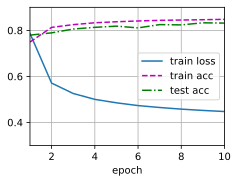

In [19]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [20]:
# 简洁实现的训练精度和测试精度
d2l.evaluate_accuracy(net,train_iter), d2l.evaluate_accuracy(net,test_iter)

(0.8471833333333333, 0.8317)

- 和以前一样，这个算法使结果收敛到一个相当高的精度，而且这次的代码比之前更精简了。

## 小结

* 使用深度学习框架的高级API，我们可以更简洁地实现softmax回归。
* 从计算的角度来看，实现softmax回归比较复杂。在许多情况下，深度学习框架在这些著名的技巧之外采取了额外的预防措施，来确保数值的稳定性。这使我们避免了在实践中从零开始编写模型时可能遇到的陷阱。
